# Nepreda, or: A minimum viable project in SAM

The goal of this notebook is to show how a project could be done (hopefully) relatively simple by using the SAM package, in addition to pandas and scikit-learn.

This minimum viable project will still need the usual: problem definition, data collection, etcetera. This notebook assumes we already have our data, and we know our problem: predicting a certain column. (???) For the sake of completeness, we will show two possible problems: quantile regression, as well as binary classification.

The project will consist of these steps:

1. Loading the data - synthetic data will be loaded from sam.data_sources
2. Plotting the data for visual inspection: This will not be comprehensive, because more work on this is planned in T224
3. Preprocessing - using functions from sam.preprocessing to take out extreme or incorrect values
4. Feature engineering - using sam.feature_engineering to create rolling features
5. Feature selection - calculating autocorrelation using sam.feature_selection
6. Modelling - doing quantile regression using scikit-garden
7. Modelling - doing binary classification using scikit-learn
8. Writing the results in such a way they can be visualized using the shiny dashboard being developed in T305

Other:
* Writing data to/from MongoDB in between steps
* Logging results to MLFlow

In [1]:
# Libraries and magic needed for all sections.
# A minor goal of this notebook is that every section can be executed independently. 
# However, for that to work, this cell needs to be executed before everything else.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%aimport sam

from sam.utils.mongo_wrapper import MongoWrapper

## Load the data
We load the (raw immutable) data using synthetic data. This snippet is quite long, because it's highly parameterized - these parameters were found with trial and error, and chosen to resemble nereda data as much as possible. Then, we write it to MongoDB.

This (long) code is obviously not neccecary with a real project - there, you can just load the data from csv or whatever format. In that case, only the second cell in this section is needed, and the first cell can be ignored.

In [2]:
from sam.data_sources import create_synthetic_timeseries, synthetic_date_range

def create_nereda_skeleton(start='2016-01-01', end='2017-05-01', freq='6H',
                           unit_name='WSV_EPE_Nereda01',
                           max_delay=700, random_stop_freq=0.002, random_stop_max_length=50):

    index = synthetic_date_range(start, end, freq, max_delay, random_stop_freq, random_stop_max_length)

    start_date = index[:-1]
    end_date = index[1:]
    # Id is unique for a reactor, but not for all reacors
    id = np.random.choice(10**6, len(start_date), replace=False)
    result = pd.DataFrame({'HistBatchStartDate': start_date.values,
                           'HistBatchEndDate': end_date.values,
                           'UnitName': unit_name, 'Id': id
    }, columns=['HistBatchStartDate', 'HistBatchEndDate', 'UnitName', 'Id'])
    return result


def create_synthetic_nereda(units=['WSV_EPE_Nereda01', 'WSV_EPE_Nereda02'], **kwargs):

    result = pd.DataFrame({})
    for unit in units:
        data = create_nereda_skeleton(unit_name = unit, **kwargs)
        data['AERATION'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=5, daily=2, hourly=10, monthnoise=('normal', 3), daynoise=('normal', 0.2),
                         noise={'normal': 0.1}, minmax_values=(10, 100), cutoff_values=None)
        data['INFLUENT'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=2, daily=2, hourly=6, monthnoise=('normal', 0.5), daynoise=('poisson', 1),
                         noise={'poisson': 0.1}, minmax_values=(0, 4000), cutoff_values=None, negabs=1500) + 200
        data['NH4'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=0.1, daily=0.5, hourly=0.3, monthnoise=('poisson', 0.1), daynoise=('poisson', 0.3),
                         noise={'normal': 0.1, 'poisson': 0.2}, minmax_values=(0, 25), cutoff_values=(0, 20))
        data['NO3'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=6, daily=3, hourly=0.3, noise={'normal': 0.2, 'poisson': 0.5},
                         minmax_values=(0, 21), cutoff_values=(0, 20))
        data['PO4'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=0, daily=0.02, hourly=0, monthnoise=('normal', 0.0), daynoise=('poisson', 0.2),
                         noise={'normal': 0.05, 'poisson': 0.01}, minmax_values=(0, 3), cutoff_values=None)
        data['TEMPERATURE'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=5, daily=1, hourly=0.0, monthnoise=('normal', 0.01), daynoise=('normal', 0.01),
                         noise={'normal': 0.1}, minmax_values=(5, 25), cutoff_values=None, random_missing=0.12)
        data['TURBIDITY'] = create_synthetic_timeseries(data.HistBatchStartDate,
                         monthly=0, daily=0.02, hourly=0, monthnoise=('normal', 0.0), daynoise=('poisson', 0.1),
                         noise={'normal': 0.05, 'poisson': 0.01}, minmax_values=(0, 50), cutoff_values=None)
        
        firstvalid, lastvalid = data.AERATION.first_valid_index(), data.AERATION.last_valid_index()
        data = data.iloc[firstvalid:lastvalid] # We get rid of the nans at the beginning/end due to the spline
        result = pd.concat([result, data], ignore_index=True)
    return result

In [3]:
# Read the data (in this case from a synthetic data generator)
data = create_synthetic_nereda(units=['WSV_EPE_Nereda01', 'WSV_EPE_Nereda02'], start='2010-01-01', end='2017-05-01')
# Write the data to mongoDB
MongoWrapper('T277','raw_immutable').empty().add(data)

/home/fenno/sam/sam/data_sources/synthetic_data.py:184: RuntimeWarning: invalid value encountered in less
  data = np.where((data < cutoff_values[0]) | (data > cutoff_values[1]), np.nan, data)
/home/fenno/sam/sam/data_sources/synthetic_data.py:184: RuntimeWarning: invalid value encountered in greater
  data = np.where((data < cutoff_values[0]) | (data > cutoff_values[1]), np.nan, data)


# Plot the data for visual inspection
For now, I'm just going to do some basic time series plots, and use pandas profiling. In the future, SAM will offer more data exploration/visualization tools.

The results of pandas_profiling can be [found here](http://10.2.0.20/pandasprofilingexample_sam.html).

In [4]:
import pandas_profiling

data = MongoWrapper('T277','raw_immutable').get().sort_values(['UnitName', 'HistBatchStartDate'])

profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile="output.html")

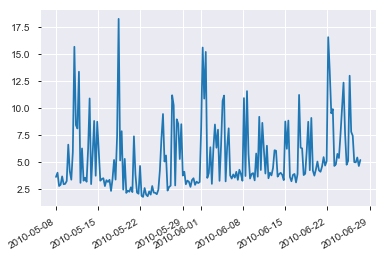

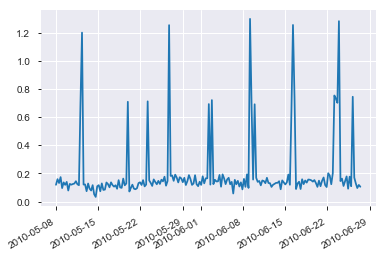

In [5]:
# This shows histograms, correlations and missing values. In this case there are no warnings, other than that TEMPERATURE has some missing values.
# It does not show time series. To do that, we can do stuff like:

# Helper function to show a line plot while preventing the date labels from overlapping
def simple_timeseries(time, values, ix0=0, ix1=100):
    %matplotlib inline
    fig, ax = plt.subplots()
    ax.plot_date(time.iloc[ix0:ix1], values.iloc[ix0:ix1],
                 marker='', linestyle='-')
    fig.autofmt_xdate()
    plt.show()

simple_timeseries(data.HistBatchStartDate, data.NH4, 500, 700)
simple_timeseries(data.HistBatchStartDate, data.PO4, 500, 700)
# Etcetera. I'm not going to plot everything here because that's not the point.
# In a real project, you would at least look at the data a little closer than I am to find unintuitive things that may be important.

# Preprocessing

In this secion, we will preprocess the data. For now that just involves getting rid of extreme values
We are not going to 'complete' timestamps because that is not relevant for nereda, (because batches are discrete events)
But complete_timestamps should be considered for other projects where the sensor data is not so discrete. You should also consider completing timestamps to fill gaps - lag features are not as meaningful if there are random gaps days or weeks between batches.

In practice, other preprocessing steps will often need to be taken. These include project-specific steps, such as
* Pivoting the table from long to wide
* Adding a datetime object

In fact, some of these steps may even need to be done before the previous step (visual inspection). 
Because this process is always highly project-specific, we cannot give general rules in this notebook, other than: Try to get the data into a standard dataframe format, with columns containing KPI's, and rows containing a unique sensor+time combination. In our example, we can skip some of this 'janitor' work, because the function 'create_synthetic_nereda' returns data that is already in this format.

In [6]:
from sam.preprocessing import correct_outside_range
data = MongoWrapper('T277','raw_immutable').get()

data = correct_outside_range(data, 'NH4', (0, 20), 'na')
data = correct_outside_range(data, 'NO3', (0, 20), 'na')
data = correct_outside_range(data, 'PO4', (0, 10), 'na')
data = correct_outside_range(data, 'TURBIDITY', (0, 50), 'na')

MongoWrapper('T277','preprocessed').empty().add(data)

INFO:sam.preprocessing.correct_extremes:Correct_outside_range changed 0 values using method na
INFO:sam.preprocessing.correct_extremes:The column NH4 previously had 32 missing values, now it has 32
INFO:sam.preprocessing.correct_extremes:Correct_outside_range changed 0 values using method na
INFO:sam.preprocessing.correct_extremes:The column NO3 previously had 4 missing values, now it has 4
INFO:sam.preprocessing.correct_extremes:Correct_outside_range changed 0 values using method na
INFO:sam.preprocessing.correct_extremes:The column PO4 previously had 0 missing values, now it has 0
INFO:sam.preprocessing.correct_extremes:Correct_outside_range changed 0 values using method na
INFO:sam.preprocessing.correct_extremes:The column TURBIDITY previously had 0 missing values, now it has 0


# Feature engineering

This pipeline is where engineering comes in. This is just an example. Also, consider the tsfresh package, which has many feature engineering functions for time series.

This section just shows some of the possibilities of the SAM package. In the future, 'standard' feature engineering may be added to SAM, as a suggestion of what features can be used. This way, some of the feature engineering will be done for you.

In [7]:
# Helper class: use FunctionTransformer with get_feature_names
# Only works if the function returns a pandas dataframe (or other object with .column.values attribute)
from sklearn.preprocessing import FunctionTransformer

class FunctionTransformerWithNames(FunctionTransformer):
    def transform(self, X, y='deprecated'):
        output = super(FunctionTransformerWithNames, self).transform(X, y)
        self._feature_names = list(output.columns.values)
        return output
    def get_feature_names(self):
        return self._feature_names

In [8]:
data = MongoWrapper('T277','raw_immutable').get()

# Project specific feature engineering:
# although these features are not super creative, they should probably be used in any project with discrete batches
data['BATCH_DURATION'] = (data.HistBatchEndDate - data.HistBatchStartDate).dt.seconds
# This column is pretty useless because it's always 0... But lets see if it's filtered out during feature selection!
data['TIME_SINCE_PREVIOUS'] = data.groupby('UnitName').apply(lambda x: (x.HistBatchStartDate - x.HistBatchEndDate.shift()).dt.seconds).values

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sam.feature_engineering.rolling_features import BuildRollingFeatures
from sam.feature_engineering import decompose_datetime

# Showing the possibilities of the ColumnTransformer together with BuildRollingFeatures
# This can maybe be made a bit easier:
# - make keep_original False a default
# - make a built-in decompose_datetime with get_feature_names

# However, the idea of a large transformer pipeline is still useful. Ideally, we would even add the previous cell to this as well.


kpi_cols = ['INFLUENT','NH4','NO3','PO4','TEMPERATURE','TURBIDITY','BATCH_DURATION','TIME_SINCE_PREVIOUS']
fourier_cols = ['INFLUENT','NH4','NO3','PO4','TEMPERATURE','TURBIDITY']
time_cols = ['HistBatchStartDate']

# Make decompose_datetime work with FeatureTransformerWithNames
time_transformer = lambda dates: decompose_datetime(dates, 'HistBatchStartDate', ['hour', 'day', 'month', 'weekday'])

nereda_features = Pipeline([
    ("kpi_lags", ColumnTransformer([
        # Lag features
        ("lag", BuildRollingFeatures(rolling_type='lag', window_size = [1,2], lookback=0, keep_original=False), kpi_cols),

        # Summary of the last week
        ("max_week", BuildRollingFeatures(rolling_type='max', window_size = 28, keep_original=False), kpi_cols),
        ("min_week", BuildRollingFeatures(rolling_type='min', window_size = 28, keep_original=False), kpi_cols),
        ("mean_week", BuildRollingFeatures(rolling_type='mean', window_size = 28, keep_original=False), kpi_cols),

        # Summary of the last day
        ("max_day", BuildRollingFeatures(rolling_type='max', window_size = 4, keep_original=False), kpi_cols),
        ("min_day", BuildRollingFeatures(rolling_type='min', window_size = 4, keep_original=False), kpi_cols),
        ("mean_day", BuildRollingFeatures(rolling_type='mean', window_size = 4, keep_original=False), kpi_cols),

        # Fourier features
        ("fourier", BuildRollingFeatures(rolling_type='fourier', window_size = 28, keep_original=False), fourier_cols),
        
        ("timefeats", FunctionTransformerWithNames(time_transformer, validate=False), time_cols),
        
        # Also use the kpi_cols themselves as features because why not. This is much easier than concatting them later
        # the FunctionTransformerWithNames is trivial, but is needed to get 'get_feature_names' to work
        ("passthrough", FunctionTransformerWithNames(lambda x: x, validate=False), kpi_cols)
    ], remainder='drop'))  # Drop the useless 'Id' column. Columns can be passed through if needed, see documentation of ColumnTransformer
])

In [10]:
# We are going to continue by training a different model for each reactor.
# If this is not desired, some sklearn finagling will have to be done to prevent errors
# (e.g.: lag will leak a little bit if there are multiple reactors in the dataframe)
reactor = "WSV_EPE_Nereda01"
data = data.query('UnitName == "{}"'.format(reactor)).sort_values(['HistBatchStartDate'])  # data must be sorted for RollingFeatures

# Apply the sklearn pipeline.
result = nereda_features.fit_transform(data)
result = pd.DataFrame(result, columns = nereda_features.named_steps['kpi_lags'].get_feature_names())

# Write it to the table: features_WSV_EPE_Nereda01
MongoWrapper('T277','features_{}'.format(reactor)).empty().add(result)
result.head(2)

INFO:sam.logging.new_columns:Removed columns: ['NH4', 'TEMPERATURE', 'TURBIDITY', 'PO4', 'INFLUENT', 'BATCH_DURATION', 'NO3', 'TIME_SINCE_PREVIOUS']
INFO:sam.logging.new_columns:Added new columns: ['NO3_lag_1', 'NH4_lag_2', 'TEMPERATURE_lag_1', 'INFLUENT_lag_1', 'TURBIDITY_lag_1', 'NO3_lag_2', 'INFLUENT_lag_2', 'BATCH_DURATION_lag_1', 'TIME_SINCE_PREVIOUS_lag_1', 'BATCH_DURATION_lag_2', 'PO4_lag_2', 'NH4_lag_1', 'TEMPERATURE_lag_2', 'TURBIDITY_lag_2', 'TIME_SINCE_PREVIOUS_lag_2', 'PO4_lag_1']
INFO:sam.logging.new_columns:Removed columns: ['NH4', 'TEMPERATURE', 'TURBIDITY', 'PO4', 'INFLUENT', 'BATCH_DURATION', 'NO3', 'TIME_SINCE_PREVIOUS']
INFO:sam.logging.new_columns:Added new columns: ['TURBIDITY_max_28', 'TIME_SINCE_PREVIOUS_max_28', 'NH4_max_28', 'NO3_max_28', 'INFLUENT_max_28', 'TEMPERATURE_max_28', 'BATCH_DURATION_max_28', 'PO4_max_28']
INFO:sam.logging.new_columns:Removed columns: ['NH4', 'TEMPERATURE', 'TURBIDITY', 'PO4', 'INFLUENT', 'BATCH_DURATION', 'NO3', 'TIME_SINCE_PREVIOUS

,lag__INFLUENT_lag_1,lag__NH4_lag_1,lag__NO3_lag_1,lag__PO4_lag_1,lag__TEMPERATURE_lag_1,lag__TURBIDITY_lag_1,lag__BATCH_DURATION_lag_1,lag__TIME_SINCE_PREVIOUS_lag_1,lag__INFLUENT_lag_2,lag__NH4_lag_2,...,timefeats__HistBatchStartDate_month,timefeats__HistBatchStartDate_weekday,passthrough__INFLUENT,passthrough__NH4,passthrough__NO3,passthrough__PO4,passthrough__TEMPERATURE,passthrough__TURBIDITY,passthrough__BATCH_DURATION,passthrough__TIME_SINCE_PREVIOUS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4,437.613,5.1439,9.07506,0.443173,17.7915,9.92008,22001,0
1,437.613,5.1439,9.07506,0.443173,17.7915,9.92008,22001,0,NaN,NaN,...,1,4,812.364,7.40063,8.28661,0.6726,17.7631,9.09001,22104,0


# Feature selection

We now have 160 features (and 1 target). This means it may be time to do a little feature selection! There are many methods of feature selection, and it is reccommended to use one of the many great methods already in sklearn! We did not reimplement them in SAM, because they are already in sklearn!

For example, we could train a simple random forest model, and choose only those features with the highest feature importance. In this section, we don't show that (just google it or something), but we show three other methods of feature selection.

* Sklearn - SelectKBest
* Sam - top_correlations
* autocorrelation plot

Importantly! feature selection in a real project should be done on train data only, instead of on all data.

In [11]:
from sam.feature_selection.top_correlation import retrieve_top_n_correlations
reactor = "WSV_EPE_Nereda01"
target = 'passthrough__NH4'

data = MongoWrapper('T277','features_{}'.format(reactor)).get()
y = data[[target]]
X = data.drop([target], axis=1)

In [12]:
# SelectKBest is the easiest to get a proof-of-concept. In just a few lines of code, we pick the most useful columns.
# However, it is probably the hardest to explain to a customer. Also, you need to be careful in deployment: fit_transform will not always return the same columns.
# f_score is a widely applicable score. In a project, probably think about it a little if you want to use chi2 or mi or f_score (or even correlation)

# IMPORTANT: for now, it doesn't work because of missing values... I chose to ignore it because this is not sam functionality, but just showing an alternative.

if False:
    from sklearn.feature_selection import SelectKBest, f_regression
    feature_selector = SelectKBest(f_regression, k=50).fit(X, y)
    X_new = feature_selector.transform(X)

# If you just want feature selection with pearson without manual work, I would reccommend using the 'abs_pearson_correlation' function shown here, 
# and just use SelectKBest as seen above (replace f_regression with abs_person_correlation)

def abs_pearson_corr(X, y):
    from scipy.stats import pearsonr
    corr_and_p = np.apply_along_axis(lambda x: pearsonr(x, y), 0, X)
    return(np.abs((corr_and_p[0, :]), corr_and_p[1, :]))

,index,GROUP,passthrough__NH4
0,mean_day__NH4_mean_4,mean,0.348068
1,min_day__NH4_min_4,min,0.328084
2,lag__NH4_lag_1,lag,0.325594
3,mean_week__NH4_mean_28,mean,0.323999
4,max_day__NH4_max_4,max,0.287441


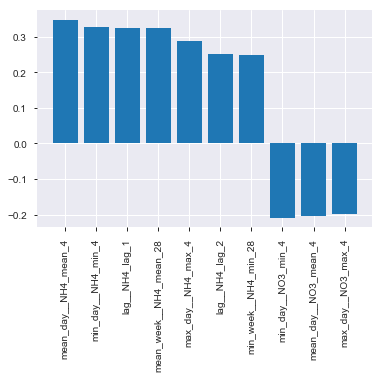

In [13]:
# This method is less 'easy', but more of an exploration tactic.
# This method is more meant for manual inspection, and perhaps even visualization in a bar plot of sorts
result = retrieve_top_n_correlations(data, target, 100, grouped=False)

%matplotlib inline
plt.bar(result[['index']][:10].values.ravel(), result[[target]][:10].values.ravel())
plt.xticks(rotation=90)
result.head(5)

In [14]:
# Autocorrelation plot
# not implemented yet. See T352

from sam.feature_selection.lag_correlation import create_lag_correlation

# Binary classification

For this example, we will be using 'passthrough__NH4' as the target, and will be doing binary classification: is there an incident coming up.
Predicting incidents in the future instead of only for the current moment is obviously more interesting. Therefore, our goal variable will become: 'is there an incident coming up in the next 1-5 datapoints? Here, 1-5 is an arbitrary choice. Incident is defiend as 'passthrough__NH4' > 10 for a specific datapoint.
10 is chosen the same as Nereda, although the synthetic data does not neccecarily have the same proportion of > 10 as the original data did.
Incident recall is defined here: http://10.2.0.20/sam/metrics.html

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


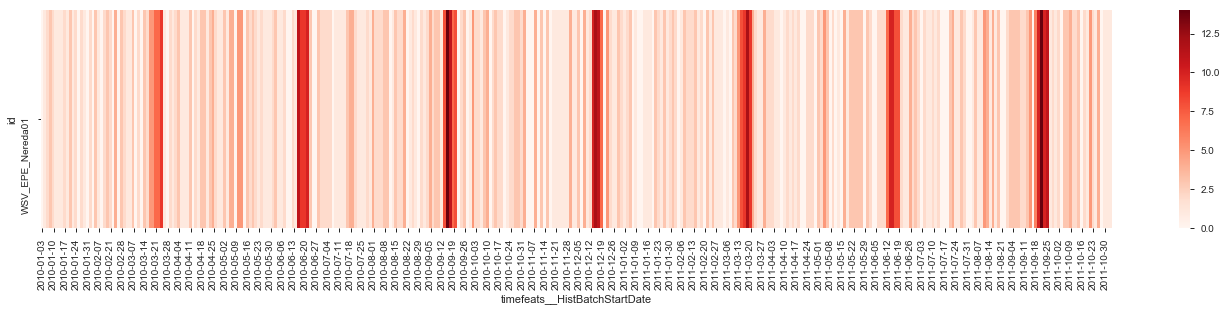

In [15]:
from sam.visualization import make_incident_heatmap

reactor = "WSV_EPE_Nereda01"
target = 'passthrough__NH4'
cutoff = 10
data = MongoWrapper('T277','features_{}'.format(reactor)).get()

data['id'] = reactor
data['incident'] = data[[target]].values.ravel() > cutoff

# Step 1: see how many incidents there even are
# The date labels are very ugly, but will hopefully be fixed in the future. See T353
make_incident_heatmap(data, resolution='W', time_column='timefeats__HistBatchStartDate', cmap='Reds', datefmt="%Y-%m-%d")

In [16]:
# Doing the actual modelling.
# This is also where MLFlow comes in.

import mlflow
mlflow.set_tracking_uri("http://10.2.0.20:5000")

# This create_experiment will fail because it's already created.
# Therefore, we rely on a magic number.
# experiment_id = mlflow.create_experiment('sam_demo_T277')
experiment_id = 21

reactor = "WSV_EPE_Nereda01"
data = MongoWrapper('T277','features_{}'.format(reactor)).get()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sam.feature_engineering import range_lag_column

target = 'passthrough__NH4'
cutoff = 10
range_pred = (1, 5)

# Here we finally calculate the actual target column. Did an incident happen in the next 1-5 datapoints?
# If an incident happens in the current data point, it's not interesting, because we already know there is an incident happening
# We want to predict: is there an incident coming up in the future?
data['outcome'] = range_lag_column(data[target] > cutoff, range_pred)

drop_cols = ['timefeats__HistBatchStartDate', 'outcome']  # To be dropped from X later.
# target can just be used, because we want to predict the FUTURE value, not the current value. Of course 'outcome' is not okay to use.

# We save a holdout set, to try the performance on later.
holdout = data.loc[data['timefeats__HistBatchStartDate'].dt.year == 2017]
cv_set = data.loc[data['timefeats__HistBatchStartDate'].dt.year < 2017]

# We use group shuffle split. This ensures the splits are fair: years are always kept together.
year_split = cv_set['timefeats__HistBatchStartDate'].dt.year

y = cv_set['outcome']
X = cv_set.drop(drop_cols, axis=1)


# RF doesn't take NaN for an answer, so fill with -9999
X = X.fillna(-99999)

# It's scikit-learn time!
# As mentioned in the Feature Selection section, feature selection should ideally be done on only the train set
# This is where this can be configured, in the 'estimator' parameter. This could be a pipeline (and in fact, that is reccommended!)
# Alternitively, we can forego gridsearch and just use a single train/test split. (in this case, a pipeline is still a good idea!)
grid_search_params = {
    "estimator" : RandomForestClassifier(n_estimators = 50, min_samples_split = 10),
    "scoring" : "roc_auc",
    "n_jobs" : -1,
    "cv" : GroupShuffleSplit(n_splits = 5, train_size = 0.8, test_size = 0.2, random_state = 42).split(X, y, year_split),
    "param_grid" : {
        "class_weight" : [None, "balanced"]
    },
    "return_train_score" : True,
    "iid" : False
}

In [18]:
# Do the actual machine learning
clf = GridSearchCV(**grid_search_params)
_ = clf.fit(X, y)

In [19]:
# Now that ML is done, we cal start logging to MLFlow
import mlflow.sklearn as mlflow_sklearn
# Also show off some visualizations from sam
from sam.visualization import make_precision_recall_curve
# We don't have make_precision_incident_recall_curve yet, but will probably be added in the future
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sam.metrics import incident_recall

# There can be multiple results, after all, we are doing grid search
# In this case, we only try 2 variations: class_weight is either None or "balanced"
# Each parameter set trains multiple models, but only gives 1 record
# If you are not doing parameter search, this is obviously useless
# However, the code will only be more straightforward if you don't do grid search, but just a single model.
all_results = pd.DataFrame(clf.cv_results_)
    
# holdout scoring
y_incidents = holdout[target] > cutoff
X_holdout = holdout.drop(drop_cols, axis=1)
X_holdout = X_holdout.fillna(-99999)
y_holdout = holdout["outcome"]

y_pred = clf.best_estimator_.predict(X_holdout)
y_pred_proba = clf.best_estimator_.predict_proba(X_holdout)

ax = make_precision_recall_curve(y_holdout, [a[1] for a in y_pred_proba])

ax.figure.savefig("output/visualizations/precision_recall_curve.png")
plt.close()

for i, result in all_results.iterrows():
    with mlflow.start_run(experiment_id=experiment_id):
        # Overall parameters
        mlflow.log_param("Target", target)
        mlflow.log_param("Cutoff", cutoff)
        mlflow.log_param("range_pred", str(range_pred))

        for key in grid_search_params:
            mlflow.log_param(key, str(grid_search_params[key]).replace('\n', ' '))

        # Result of GridSearchCV
        params = result["params"]
        for key, value in result.items():
            if ((key == "params") | key.startswith("param_")):
                continue
            mlflow.log_metric(key, value)
        for key, value in params.items():
            mlflow.log_param(key, value)

        # Holdout metrics
        mlflow.log_metric("Holdout number_positive", np.sum(y_holdout))
        mlflow.log_metric("Holdout percentage_positive", np.sum(y_holdout) / y_holdout.size)
        mlflow.log_metric("Holdout number_of_incidents", np.sum(y_incidents))
        mlflow.log_metric("Holdout total_size", y_holdout.size)
        mlflow.log_metric("Holdout precision", precision_score(y_holdout, y_pred))
        mlflow.log_metric("Holdout Recall", recall_score(y_holdout, y_pred))
        mlflow.log_metric("Holdout Incident recall", incident_recall(y_incidents, y_pred, range_pred))
        mlflow.log_metric("Holdout Incident recall plus one", incident_recall(y_incidents, y_pred, (range_pred[0] + 1, range_pred[1])))
        mlflow.log_metric("Holdout auc", roc_auc_score(y_holdout, [a[1] for a in y_pred_proba]))

        # Misscelaneous and artifcats
        with open("output/visualizations/features.txt", 'w') as filetowrite:
            filetowrite.write(str(list(X.columns.values)))
            filetowrite.close()
        mlflow.log_artifact("output/visualizations/features.txt")
        mlflow_sklearn.log_model(grid_search_params["estimator"], "estimator_unfit")
        mlflow_sklearn.log_model(clf.best_estimator_, "best_estimator")
        mlflow.log_artifact("output/visualizations/precision_recall_curve.png")

        if hasattr(clf.best_estimator_, 'feature_importances_'):
            with open("output/visualizations/feature_importance.txt", 'w') as filetowrite:
                tuples = zip(list(clf.best_estimator_.feature_importances_), list(X.columns.values))
                tuples = sorted(tuples, reverse = True)
                result = "\n".join([name + ": " + str(imp) for imp, name in tuples])
                filetowrite.write(result)
                filetowrite.close()
            mlflow.log_artifact("output/visualizations/feature_importance.txt")


# See the results here:
# http://10.2.0.20:5000/#/experiments/21

# Quantile Regression

In this section, show off quantile regression. No MLFlow because I'm just trying to get this done. ¯\\_(ツ)_/¯

In this case, we are showing off just a single model. The process of turning it into a grid search and adding mlflow is the same as above.

In [20]:
from skgarden import RandomForestQuantileRegressor

reactor = "WSV_EPE_Nereda01"
target = 'passthrough__NH4'

data = MongoWrapper('T277','features_{}'.format(reactor)).get()

# We save a holdout set, to try the performance on later.
test = data.loc[data['timefeats__HistBatchStartDate'].dt.year == 2017]
train = data.loc[data['timefeats__HistBatchStartDate'].dt.year < 2017]
drop_cols = ['timefeats__HistBatchStartDate', target]

# For quantile regression, an important point counts: we don't use the target column, but we often want to use some lagged version of the target
# This lag depends on what kind of outliers we are trying to detect: long or short-term outliers. This is a longstanding discussion at hydrotwin...
# In this case, we use all kind of lagged variables, so it's extremely short-term outliers... :) Obviously in practice, you probably want to
# change the feature generating pipeline a little bit to not include 20+ different short-term lagged versions of the target, but maybe just 1 or 2.

y_train = train[target]
X_train = train.drop(drop_cols, axis=1)
# RF doesn't take NaN for an answer, so fill with -9999
X_train = X_train.fillna(-99999)
y_train = y_train.fillna(-1) # Bit hacky... oh well

# Potentially do feature selection here. Not for now.
clf = RandomForestQuantileRegressor(min_samples_split=10, n_estimators=50, n_jobs=-1)

In [21]:
# Do the machine learning
clf.fit(X_train, y_train)

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=10,
               min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)

In [22]:
y_test = test[target]
X_test = test.drop(drop_cols, axis=1)
X_test = X_test.fillna(-99999)

lower = clf.predict(X_test, quantile=20)
medium = clf.predict(X_test, quantile=50)
upper = clf.predict(X_test, quantile=80)

In [23]:
from sam.train_models import find_outlier_curves

dashboard_data = pd.DataFrame({
    "TIME": test.timefeats__HistBatchStartDate,
    "PREDICT": medium,
    "ACTUAL": y_test,
    "ID": reactor,
    "PREDICT_LOW": lower,
    "PREDICT_HIGH": upper
}).reset_index()
# Now calculate the outlier 'curves'
# For more information, see documentation.
# Batches are 6 hours, quite long, so default parameters will work fine. (no gaps, etc.)
dashboard_data["OUTLIER"] = find_outlier_curves(dashboard_data)

dashboard_data.to_csv("output/quantile_output.csv")

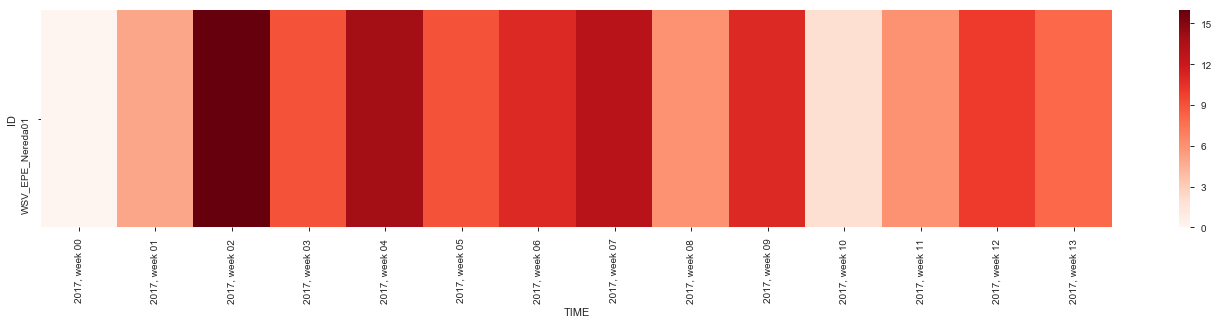

In [24]:
# Calculate outliers per week.
# Useful for making a heatmap
from sam.visualization import make_incident_heatmap
dashboard_data['incident'] = dashboard_data.OUTLIER > 0
make_incident_heatmap(dashboard_data, resolution="W", row_column="ID", time_column="TIME", cmap="Reds", datefmt="%Y, week %W")

# Calculate the grouped_df ourself (copying code from the heatmap function)
df_grouped = dashboard_data.groupby(["ID", pd.Grouper(key="TIME", freq="W")])
df_grouped = df_grouped["incident"].sum().unstack(fill_value=0).transpose().reset_index()
df_grouped.head(5)

df_grouped.to_csv("output/heatmap_output.csv")

# These two files can now be read in R and used to make a nice, material dashboard :D

## Potential next steps

This document covered the first steps of exploring the data, fixing issues, and eventually training a model. One of the next steps should be making your code more reproducible, by moving the individual parts (preprocessing, feature engineering, etc) to functions, and away from a jupyter notebook. Then, the potential trained models should eventually be pickled, and moved to production somehow. When moving to production, an actual 'pipeline' can also be very useful as a method to automatically preprocess and train/predict. 